# Importowanie bibliotek

In [209]:
from scipy.signal import TransferFunction, lsim, lsim2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

# Definiowanie parametrów symulacji

In [210]:
steps=600
sampling=0.5
signal_t = np.linspace(0,(steps-1)*sampling, steps)
q1 = np.ones_like(signal_t)
q2 = np.ones_like(signal_t)
q2[:100] = 0

Na potrzeby pokazania odpowiedzi skokowej zdefiniowanego modelu powstały dwa sygnały wejściowe $q1$ i $q2$, które po podaniu na model MIMO powinny wygenerować odpowiedź układu. Sygnały testowe widać poniżej:

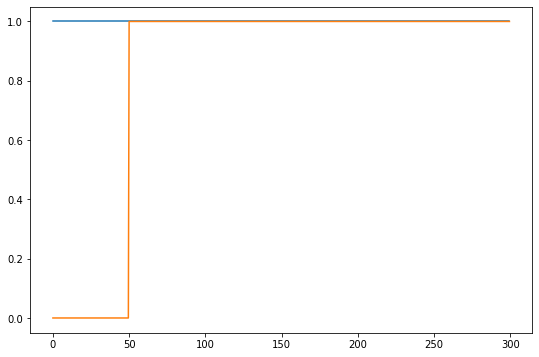

In [211]:
plt.figure(figsize=(9,6))
plt.plot(signal_t,q1)
plt.plot(signal_t,q2)

# Funkcje symulacji

Model został zrealizowany za pomocą równiań. Sam obiekt operuje na 4 zmiennych wewnętrznych, ale posiada dwa wyjścia co lepiej widać w funkcji symulacji modelRun.

In [212]:
def model(x0,t,u):
    x1 = x0[0]
    x2 = x0[1]
    x3 = x0[2]
    x4 = x0[3]

    u1 = u[0]
    u2 = u[1]
    
    dx1 = -0.1*x1 + 0.25*u1
    dx2 = -0.05*x2 + 0.125*u1
    dx3 = -1/30*x3 + 0.125*u2
    dx4 = -0.0667*x4 + 0.25*u2
    return [dx1, dx2, dx3, dx4]

Do symulacji modelu została użyta funkcja odeint, która jest również używana w matlabie od wyznaczania pochodnych sygnału.

In [213]:
def modelRun(signal_u1,signal_u2, signal_t):
    x0 = [0, 0, 0, 0]
    n = len(signal_t)
    u = [signal_u1, signal_u2]
    
    x1 = np.zeros(n)
    x2 = np.zeros(n)
    x3 = np.zeros(n)
    x4 = np.zeros(n)
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    
    for i in range(1, n):
        sim_out = odeint(model,x0,signal_t,args=([u[0][i],u[1][i]],))

        x0 = sim_out[1]
        x1[i] = x0[0]
        x2[i] = x0[1]
        x3[i] = x0[2]
        x4[i] = x0[3]
        y1[i] = 0.48*x1[i] + 0.16*x3[i]
        y2[i] = 0.2*x2[i] + 0.4*x4[i]
    
    return y1, y2

# Model bez odsprzęgania

Przykładowa odpowiedź modelu na sygnały $q1$ oraz $q2$ wygląda jak poniżej. Jak widać oba wejścia wpływają na oba wyjścia, co należy zlikwidować aby obiekt był odsprzęgnięty.

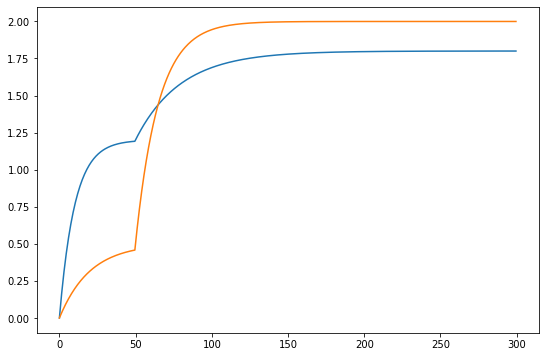

In [214]:
basic_y1, basic_y2 = modelRun(q1, q2, signal_t)

plt.figure(figsize=(9,6))
plt.plot(signal_t, basic_y1)
plt.plot(signal_t, basic_y2)

# Model z odsprzęganiem teoretycznym za pomocą transfer function

Posiadając obiekt w postaci TransferFunction można określić transmitancje potrzebne do odsprzęgnięcia obiektu.Jeżeli obiekt jest w postaci:

$$
P(s)=\begin{bmatrix}
p_{11}(s) & p_{12}(s) \\
p_{21}(s) & p_{22}(s) 
\end{bmatrix}
$$

Aby ułatwić analizowanie takiego obiektu, transmitancje obiektu można przedstawić jako model w Simulinku.

<img src='img\simulink_tf.png'>

Następnie należy określić prekompensator który będzie odsprzęgał obiekt. Klasyczny przypadek kompensatora dla obiektu TITO ma następującą postać:

<img src='img\classic_decoupler.png'>

w którym macierz transmitancji została również przedstawiona jako schemat Simulinka. Nowa macierz transmitancji obiektu musi mieć postać:

$$
G(s)=P(s)D(s)=\begin{bmatrix}
? & 0 \\
0 & ? 
\end{bmatrix}
$$

gdzie:

$$
P(s)=\begin{bmatrix}
p_{11}(s) & p_{12}(s) \\
p_{21}(s) & p_{22}(s) 
\end{bmatrix} \\
D(s)=\begin{bmatrix}
d_{11}(s) & d_{12}(s) \\
d_{21}(s) & d_{22}(s) 
\end{bmatrix}
$$

Co pozwala na niezależne od siebie powiązanie wejść do przydzielonych im wyjść.

$$
\begin{bmatrix}
y_1 \\
y_2 
\end{bmatrix} = \begin{bmatrix}
g_{11}(s) & 0\\
0 & g_{22}(s) 
\end{bmatrix}\begin{bmatrix}
q_1 \\
q_2 
\end{bmatrix}
$$

Aby obliczyć elementy odsprzęgacza można ułożyć takie równanie:

$$
\left\{\begin{matrix}
p_{11}d_{11}+p_{12}d_{21}=? \\
p_{11}d_{12}+p_{12}d_{22}=0 \\
p_{21}d_{11}+p_{22}d_{21}=? \\
p_{21}d_{12}+p_{22}d_{22}=0
\end{matrix}\right.
$$

co da takie wzory na poszczególne współczynniki:

$$
d_{11}=\frac{p_{11}p_{22}}{p_{11}p_{22}-p_{12}p_{21}} \\
d_{12}=\frac{-p_{12}p_{22}}{p_{11}p_{22}-p_{12}p_{21}} \\
d_{21}=\frac{-p_{11}p_{21}}{p_{11}p_{22}-p_{12}p_{21}} \\
d_{22}=\frac{p_{11}p_{21}}{p_{11}p_{22}-p_{12}p_{21}}
$$

Powyższy jest idealnym przypadkiem odsprzęgacza, ale można go uprościć do takich modeli:

<img src='img\simplifed_decoupler.png'>

<img src='img\inverted_decoupler.png'>

Dla pierwszego przypadku analizujemy poszczególne pętle aby wykasować wpływ jednego wejścia na drugie poprzez odpowiednie wyliczenie elementu odsprzęgacza. Dla tych odsprzęgacza w obiekcie TITO, poszczególne składowe przyjmują postać:

$$
d_{12}(s)=\frac{-p_{12}(s)}{p_{11}(s)}, \quad d_{21}(s)=\frac{-p_{21}(s)}{p_{22}(s)}
$$

czyli po wymnożenie odsprzęgacza przez obiekt otrzymamy:

$$
G(s)=\begin{bmatrix}
p_{11}(s) & p_{12}(s) \\
p_{21}(s) & p_{22}(s) 
\end{bmatrix}\begin{bmatrix}
1 & d_{12}(s) \\
d_{21}(s) & 1 
\end{bmatrix}=\\=\begin{bmatrix}
p_{11}(s)-\frac{p_{12}(s)p_{21}(s)}{p_{22}(s)} & 0 \\
0 & p_{22}(s)-\frac{p_{12}(s)p_{21}(s)}{p_{11}(s)} 
\end{bmatrix}
$$

Dla drugiego przypadku składowe wynikowa transmitancja przyjmie wartość:

$$
G(s)=\begin{bmatrix}
p_{11}(s) & 0 \\
0 & p_{22}(s) 
\end{bmatrix}
$$

Dla analizowanego układu macierz odsprzęgając wynosi:

$$
P(s)=\begin{bmatrix}
1 & 0.5*\frac{10s+1}{30s+1} \\
\frac{1}{3}*\frac{15s+1}{20s+1} & 1
\end{bmatrix}
$$

Definicja składowych tej macierzy w języku Python wygląda następująco:

In [215]:
num_12 = [-10*0.5, -1*0.5]
den_12 = [30, 1]

num_21 = [-1/3*15, -1/3]
den_21 = [20, 1]

tf_12 = TransferFunction(num_12, den_12)
tf_21 = TransferFunction(num_21, den_21)

Na każdą z tych transmitancji należy podać sygnał wejściowy jemu przypisany.

In [216]:
_, y_12, _ = lsim2(tf_12, q2, signal_t)
_, y_21, _ = lsim2(tf_21, q1, signal_t)

A następnie utworzyć nowe sygnały wejściowe dla modelu, które po zasymulowaniu wcześniej zdefiniowaną funkcją **modelRun**, pozwolą uzyskać odsprzęgniętą odpowiedź układu.

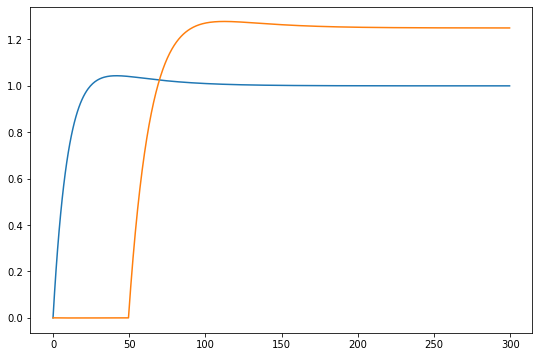

In [217]:
u1 = q1 + y_12
u2 = q2 + y_21

signal_y1, signal_y2 = modelRun(u1, u2, signal_t)

plt.figure(figsize=(9,6))
plt.plot(signal_t, signal_y1)
plt.plot(signal_t, signal_y2)

# Dane do trenowania sieci

Poprzez przeprowadzone eksperymenty określiliśmy, że sieć RNN lepiej odsprzęgla obiekt jeżeli była trenowana sygnałem podobnym do podawanego na regulator. W tym celu należy określić rodzaj i zakres podawanych na układ sygnałów sterujących. Przyjeliśmy, że układ będzie sterowany sygnałem kwadratowym z przedziału od 0 do 5. Zazwyczaj tego typu sygnały są podawane przez ukłądy DAC albo PWM, których dokładność mierzy się w bitach. Przykładowo, jeżeli posiadalibyśmy PWM 8 bitowy to możliwe wartości sygnałów podawanych na obiekt, można by zdefiniować w następujący sposób:

In [218]:
resoultion = 2**8
input_range_steps = np.linspace(0,5,resoultion)

Krok w tym przypadku wynosi $0.0196078431372549$. Jest to bardzo mały krok i aby skrócić czas trenowania sieci, postanowiliśmy dać zakres możliwych wartości wejść co $0.1$.

In [219]:
input_range_steps = np.linspace(0,5,51)

Na finalny obiekt nie będzie podawany tylko skok wznoszący, ale również opadający, dlatego do trenowania sieci należy użyć obu rodzajów sygnałów. Do stworzenia tego sygnału słóży następująca klasa:

In [220]:
class TimeSeriesData():
    def __init__(self, transfer_function, steps, start, stop):
        self.transfer_function = transfer_function
        self.steps = steps
        self.time = np.linspace(start, stop, steps)
        self.time_up_limit = int(steps/2*0.75)
        self.time_low_limit = int(steps/2*1.25)
        
    def seriesRange(self, start, stop, steps):
        self.input_range = np.linspace(start, stop, steps)
        
    def nextBatch(self):
        
        temp_input = np.ones_like(self.time)*np.random.choice(self.input_range)
        temp_input[:np.random.randint(0,self.time_up_limit)] = 0
        temp_input[np.random.randint(self.time_low_limit,self.steps):self.steps] = 0
        
        _, temp_output , _ = lsim2(self.transfer_function, temp_input, self.time)
        
        temp_output = temp_output.T
        temp_output = np.reshape(temp_output,(1,self.steps,1))
        
        temp_input = np.reshape(temp_input,(1,self.steps,1))
        
        return temp_input, temp_output

W konstruktorze klasy należy podać ilość kroków oraz zakres czasu, dla którego będa zwracane dane do trenowania sieci

In [221]:
ts_12 = TimeSeriesData(tf_12, 501, 0, 100)
ts_12.seriesRange(0,5,51)

ts_21 = TimeSeriesData(tf_21, 501, 0, 100)
ts_21.seriesRange(0,5,51)

# Definicja sieci

In [222]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, LSTM, SimpleRNN, TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

In [223]:
lin_model_12=Sequential()
lin_model_12.add(LSTM(16, input_shape=(ts_12.steps, 1),return_sequences=True))
lin_model_12.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
lin_model_12.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

In [224]:
lin_model_21=Sequential()
lin_model_21.add(LSTM(16, input_shape=(ts_21.steps, 1),return_sequences=True))
lin_model_21.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
lin_model_21.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

In [ ]:
epochs = 300
for i in range(epochs):
    model_input, model_output = ts_12.nextBatch()
    history=lin_model_12.fit(model_input, model_output , epochs=3, batch_size=1, verbose=0)
    print('Epoch: {}'.format(i+1))

In [ ]:
epochs = 300
for i in range(epochs):
    model_input, model_output = ts_21.nextBatch()
    history=lin_model_21.fit(model_input, model_output , epochs=3, batch_size=1, verbose=0)
    print('Epoch: {}'.format(i+1))

In [226]:
model_input, model_output = ts_12.nextBatch()
testPredict12 = lin_model_12.predict(model_input)
model_input, model_output = ts_21.nextBatch()
testPredict21 = lin_model_21.predict(model_input)

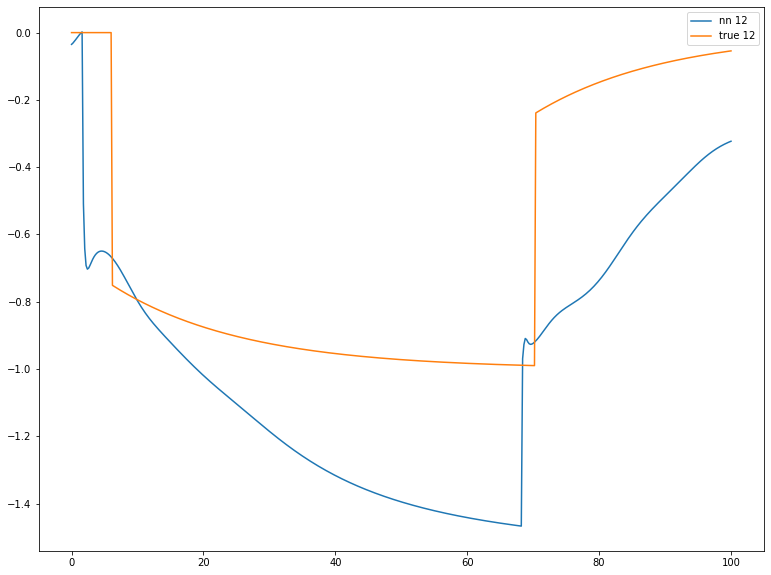

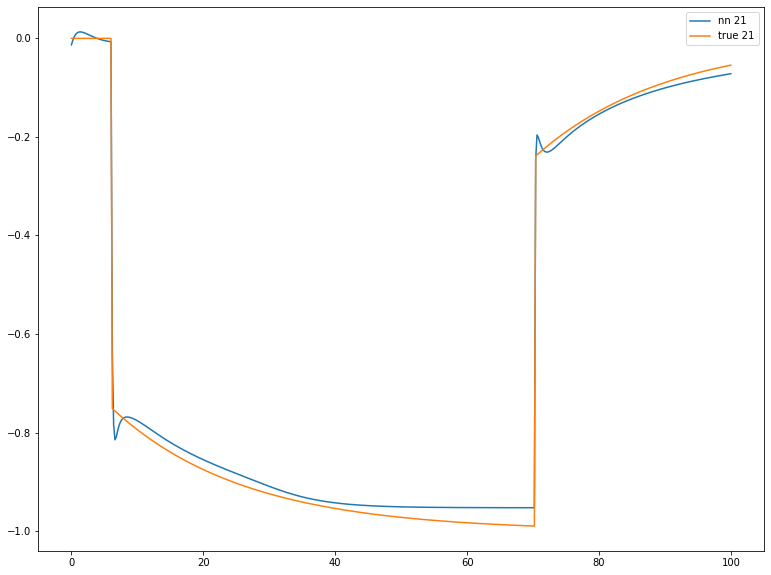

In [227]:
plt.figure(figsize=(13,10))
plt.plot(ts_12.time, testPredict12.reshape(ts_12.steps), label='nn 12')
plt.plot(ts_12.time, model_output.reshape(ts_12.steps), label='true 12')
plt.legend()
plt.figure(figsize=(13,10))
plt.plot(ts_21.time, testPredict21.reshape(ts_21.steps), label='nn 21')
plt.plot(ts_21.time, model_output.reshape(ts_21.steps), label='true 21')
plt.legend()

In [ ]:
lin_model_12.save_weights('lin_model_12.h5')
lin_model_21.save_weights('lin_model_21.h5')

In [225]:
lin_model_12.load_weights('lin_model_12.h5')
lin_model_21.load_weights('lin_model_21.h5')

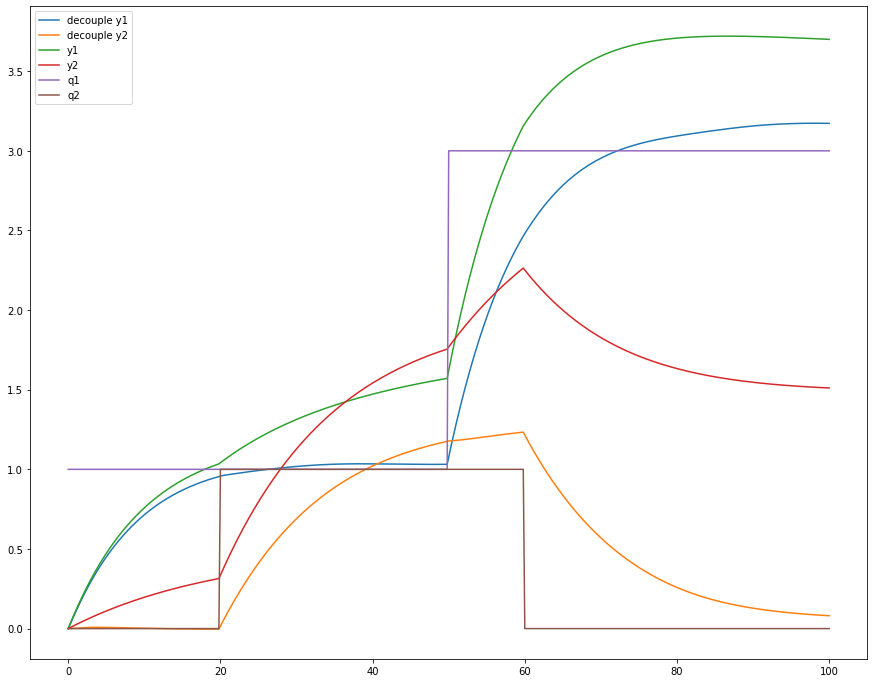

In [228]:
steps=501
signal_t = np.linspace(0,100, steps)
q1 = np.ones_like(signal_t) # *1.5
q1[250:] = 3

q2 = np.ones_like(signal_t)
q2[:100] = 0
q2[300:] = 0

y_12 = lin_model_12.predict(q2.reshape(1,steps,1))
y_21 = lin_model_21.predict(q1.reshape(1,steps,1))

u1 = q1 + y_12.reshape(steps)
u2 = q2 + y_21.reshape(steps)

signal_y1_decouple, signal_y2_decouple = modelRun(u1, u2, signal_t)
signal_y1, signal_y2 = modelRun(q1, q2, signal_t)

plt.figure(figsize=(15,12))
plt.plot(signal_t, signal_y1_decouple, label='decouple y1')
plt.plot(signal_t, signal_y2_decouple, label='decouple y2')
plt.plot(signal_t, signal_y1, label='y1')
plt.plot(signal_t, signal_y2, label='y2')
plt.plot(signal_t, q1, label='q1')
plt.plot(signal_t, q2, label='q2')
plt.legend()